In [1]:
!pip install lime


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tensorflow import keras

In [3]:
import tensorflow as tf

# 1. Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print(f"Success! TensorFlow found {len(gpus)} GPU(s):")
    for gpu in gpus:
        print(f" - {gpu}")
else:
    print("No GPU found. TensorFlow is running on CPU.")


No GPU found. TensorFlow is running on CPU.


In [4]:
# loading of the dataset
edges = pd.read_csv("dataset/musae_facebook_edges.csv")
features = pd.read_csv("dataset/musae_facebook_features.csv")
targets = pd.read_csv("dataset/musae_facebook_target.csv")
print("Edges, Features, and Targets loaded successfully.")

Edges, Features, and Targets loaded successfully.


In [5]:
# examining the dataset
print(edges.head())
print(features.head())
print(targets.head())

print("Edges shape:", edges.shape)
print("Features shape:", features.shape)
print("Targets shape:", targets.shape)


   id_1   id_2
0     0  18427
1     1  21708
2     1  22208
3     1  22171
4     1   6829
   node_id  feature_id
0      554        2835
1      554        4518
2      554        2198
3      554        2014
4      554        3818
   id       facebook_id                                     page_name  \
0   0   145647315578475                      The Voice of China 中国好声音   
1   1      191483281412                 U.S. Consulate General Mumbai   
2   2   144761358898518                                          ESET   
3   3   568700043198473  Consulate General of Switzerland in Montreal   
4   4  1408935539376139             Mark Bailey MP - Labor for Miller   

    page_type  
0      tvshow  
1  government  
2     company  
3  government  
4  politician  
Edges shape: (171002, 2)
Features shape: (314583, 2)
Targets shape: (22470, 4)


In [6]:
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
import scipy.sparse
import numpy as np

# STEP 1: Target variable
# Count total connections per node
degree_counts = (
    edges['id_1'].value_counts()
    .add(edges['id_2'].value_counts(), fill_value=0)
)

# Map degree to targets and apply log transform
targets['node_degree_log'] = np.log1p(
    targets['id'].map(degree_counts).fillna(0)
)

# STEP 2: Feature encoding
# Collect feature IDs per node
targets['feature_list'] = (
    targets['id']
    .map(features.groupby('node_id')['feature_id'].apply(list))
    .apply(lambda x: x if isinstance(x, list) else [])
)

# Multi-hot encode node features and keep the fitted encoder
mlb = MultiLabelBinarizer(sparse_output=True)
X_features = mlb.fit_transform(targets['feature_list'])

# One-hot encode page type and keep the fitted encoder
encoder = OneHotEncoder(sparse_output=True)
page_type_encoded = encoder.fit_transform(targets[['page_type']])


# STEP 3: Combine inputs
X = scipy.sparse.hstack([X_features, page_type_encoded])
y = targets['node_degree_log'].values

print(f"Data processed. Feature matrix shape: {X.shape}")


Data processed. Feature matrix shape: (22470, 4718)


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data split successfully (using Log-Transformed targets).")

Data split successfully (using Log-Transformed targets).


In [8]:
#define the regression model
from tensorflow import keras
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)  
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │       302,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,289 (1.18 MB)

 Trainable params: 308,289 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.5333 - mae: 0.4666 - val_loss: 0.1189 - val_mae: 0.2512
Epoch 2/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0940 - mae: 0.2224 - val_loss: 0.0920 - val_mae: 0.2254
Epoch 3/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0686 - mae: 0.1888 - val_loss: 0.0840 - val_mae: 0.2172
Epoch 4/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0562 - mae: 0.1695 - val_loss: 0.0761 - val_mae: 0.2053
Epoch 5/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0467 - mae: 0.1535 - val_loss: 0.0767 - val_mae: 0.2092
Epoch 6/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0422 - mae: 0.1448 - val_loss: 0.0762 - val_mae: 0.2033
Epoch 7/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0354 - mae: 0.1319 - val_loss: 0.0747 - val_mae: 0.2010
Epoch 8/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0314 - mae: 0.1232 - val_loss: 0.0764 - val_mae: 0.2075
Epoch 9/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - lo

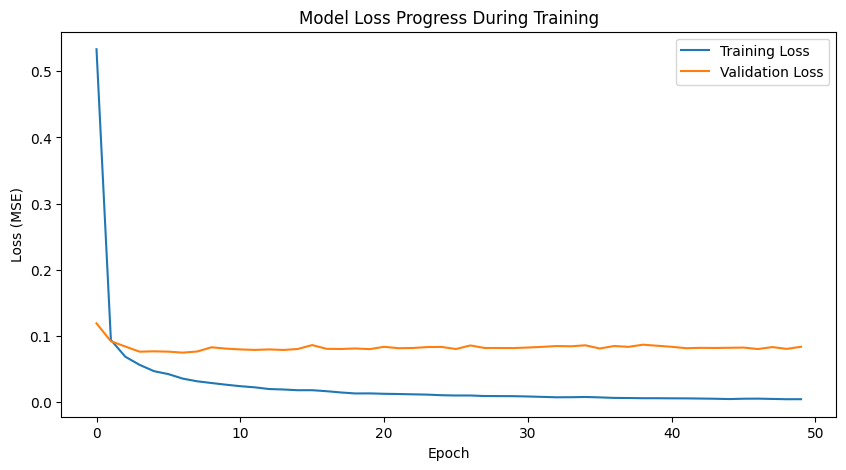

In [10]:
import matplotlib.pyplot as plt

# Plot loss (MSE) over epochs
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [11]:
# Evaluate on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)

print(f"\nFinal Test MSE (Loss): {test_loss}")
print(f"Final Test MAE: {test_mae}")

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0921 - mae: 0.2203

Final Test MSE (Loss): 0.09209252893924713
Final Test MAE: 0.22030621767044067


In [12]:
# 1. Make predictions 
preds_log = model.predict(X_test)

# 2. Convert back to Real Numbers (Inverse Log)
preds_real = np.expm1(preds_log)
y_test_real = np.expm1(y_test)

# 3. Flatten arrays to ensure they are 1D (Safe for printing)
preds_flat = preds_real.flatten()

# Handle y_test_real: flattening
if hasattr(y_test_real, 'values'):
    y_test_flat = y_test_real.values.flatten()
else:
    y_test_flat = np.array(y_test_real).flatten()

print("\nPredictions -")
for i in range(10): 
    print(f"Predicted: {preds_flat[i]:.0f} | Actual: {y_test_flat[i]:.0f}")

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Predictions -
Predicted: 1 | Actual: 1
Predicted: 1 | Actual: 1
Predicted: 84 | Actual: 109
Predicted: 5 | Actual: 3
Predicted: 8 | Actual: 7
Predicted: 2 | Actual: 2
Predicted: 19 | Actual: 16
Predicted: 4 | Actual: 5
Predicted: 44 | Actual: 60
Predicted: 2 | Actual: 2


In [13]:
# Evaluate R2 on the Log Scale 
r2_log = r2_score(y_test, preds_log)

print(f"R-squared : {r2_log:.4f}")

R-squared : 0.9149


In [15]:
import lime
import lime.lime_tabular

# Utility to safely convert sparse matrices to dense numpy arrays
import numpy as np
import scipy.sparse

def to_dense(X):
    if scipy.sparse.issparse(X):
        return X.toarray()
    return np.asarray(X)

# --- 1. Retrieve Feature Names ---
# Assumes `mlb` and `encoder` were created in the preprocessing cell

tag_names = [f"Tag_{name}" for name in mlb.classes_]

# Get page type names
page_type_names = encoder.get_feature_names_out(['page_type'])

# Combine them in the exact same order you stacked X
all_feature_names = list(tag_names) + list(page_type_names)

# --- 2. Initialize LIME with Feature Names ---
# Use a subset of training data for efficiency
X_train_dense = to_dense(X_train)

explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_dense,
    mode='regression',
    feature_names=all_feature_names,
    verbose=True
)

# --- 3. Run Explanations ---
# Example 1: Explain a specific test instance
idx = 0
print(f"Explaining prediction for test sample index {idx} with names...")

exp = explainer_lime.explain_instance(
    data_row=to_dense(X_test[idx]).flatten(),
    predict_fn=lambda x: model.predict(x).flatten(),
    num_features=10
)

# Show explanation in a text form to avoid IPython display issues
print("\nTop contributing features for sample", idx)
for feature, weight in exp.as_list():
    print(f"{feature}: {weight:.4f}")

# Example 2: Explain the test instance with highest predicted degree
preds_test = model.predict(X_test).flatten()
top_page_idx = int(np.argmax(preds_test))

print(f"\nExplaining the most popular page (Test Index: {top_page_idx})...")

exp_top = explainer_lime.explain_instance(
    data_row=to_dense(X_test[top_page_idx]).flatten(),
    predict_fn=lambda x: model.predict(x).flatten(),
    num_features=10
)

print("\nTop contributing features for the most popular page")
for feature, weight in exp_top.as_list():
    print(f"{feature}: {weight:.4f}")


Explaining prediction for test sample index 0 with names...
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
Intercept 8.141853890548976
Prediction_local [2.12575779]
Right: 0.6828355

Top contributing features for sample 0
Tag_3118 <= 0.00: -2.3229
Tag_4444 <= 0.00: -1.5808
Tag_117 <= 0.00: -0.8782
Tag_105 <= 0.00: -0.8532
Tag_3695 <= 0.00: -0.7956
Tag_4101 <= 0.00: 0.5060
Tag_762 <= 0.00: -0.4582
Tag_3520 <= 0.00: 0.3911
Tag_469 <= 0.00: -0.3064
Tag_1635 <= 0.00: 0.2822
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Explaining the most popular page (Test Index: 3374)...
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
Intercept 3.373253708232004
Prediction_local [4.31057827]
Right: 6.113653

Top contributing features for the most popular page
Tag_4444 > 0.00: 2.1468
Tag_117 <= 0.00: -1.6979
Tag_2693 <= 0.00: -1.2613
Tag_2148 <= 0.00: 0.6885
Tag_1841 <= 0.00: 0.5048
Tag_2049 <= 0.00: 0.4596
Tag_2509 <= 0.00: 0.3348
Tag_474 <= 0.00: -0.2884
Tag_3528 <= 0.00: 0.0338
Tag_625 <= 0.00: 0.0167
